In [ ]:
import splitfolders

In [ ]:
input_folders = 'F:/sleep monitoring project/Dataset reduce size/Thermal_size224/Thermal_Light_On_Resized/Thermal_Light_On_WithBlanket'
out_folders = 'F:/sleep monitoring project/Dataset reduce size/Thermal_size224/Thermal_Light_On_Resized/senghour_TV/Thermal_Light_On_WithBlanket'
splitfolders.ratio(input_folders, out_folders, seed=42, ratio=(0.8, 0.2), group_prefix=None)  # Adjust the ratio here

In [ ]:
from keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras_preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from keras_preprocessing import image
from keras.models import Sequential, Model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf

In [ ]:
# Check if GPU is available and being used
import tensorflow as tf


len(tf.config.list_physical_devices('GPU'))>0

True

In [ ]:
train_data = '/content/drive/My Drive/sleep monitoring project/TM_Lf/Thermal_Light_Off_WithoutBlanket/train'
val_data = '/content/drive//My Drive/sleep monitoring project/TM_Lf/Thermal_Light_Off_WithoutBlanket/val'
test_data = '/content/drive//My Drive/sleep monitoring project/TM_Lf/Thermal_Light_Off_WithoutBlanket/test'

In [ ]:
img_height, img_width = (224, 224)
batch_size = 32

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rescale=1.0 / 255.0,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    vertical_flip=False,
    validation_split= 0.4
)

In [ ]:
train_datagenerator = train_datagen.flow_from_directory(
    train_data,
    target_size= (img_height, img_width),
    batch_size= batch_size,
    class_mode= "categorical",
    subset= 'training'
)

val_datagenerator = train_datagen.flow_from_directory(
    val_data,
    target_size= (img_height, img_width),
    batch_size= batch_size,
    class_mode= "categorical",
    subset= 'validation'
)


Found 22745 images belonging to 5 classes.
Found 5051 images belonging to 5 classes.


In [ ]:
test_datagenerator = train_datagen.flow_from_directory(
    test_data,
    target_size= (img_height, img_width),
    batch_size= 1,
    class_mode= "categorical",
    subset= 'validation'
)

Found 5053 images belonging to 5 classes.


In [ ]:
x, y = test_datagenerator.next()
x.shape

(1, 224, 224, 3)

Pre-trained ResNet50 model

In [ ]:
# Load the pre-trained ResNet50 model without the top classification layers.
from keras.optimizers import Adam
base_model = ResNet50(include_top=False, weights='imagenet')

# Add custom classification layers on top of the base model.
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_datagenerator.num_classes, activation='softmax')(x)

# Create the model.
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

# Compile the model with Adam optimizer and categorical cross-entropy loss.
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
histrory = model.fit(train_datagenerator, validation_data= val_datagenerator, epochs=150)

Epoch 1/150
 25/711 [>.............................] - ETA: 1:36:10 - loss: 1.6265 - accuracy: 0.2075

In [ ]:
# Plotting Training
plt.plot(histrory.history['loss'], '-', color='red', label='Training Loss')
plt.plot(histrory.history['val_loss'], '-', color='green', label='Validation Loss')
plt.plot(histrory.history['accuracy'], '-', color='black', label='Train Accuracy')
plt.plot(histrory.history['val_accuracy'], '-', color='Blue', label='Validation Accuracy')
plt.title('Average Training and Validation Set Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
train_loss, train_acc = model.evaluate(train_datagenerator, verbose=2)
val_loss, val_acc = model.evaluate(val_datagenerator, verbose=2)
test_loss, test_acc = model.evaluate(test_datagenerator, verbose=2)


print(f"Training Accuracy: {train_acc} and Training Loss: {train_loss}")
print(f"Validation Accuracy: {val_acc} and Validation Loss: {val_loss}")
print(f"Test Accuracy: {test_acc} and Test Loss: {test_loss}")

In [ ]:
filename= test_datagenerator.filenames
nb_sample = len(test_datagenerator)
y_prob = []
y_act = []
test_datagenerator.reset()

for _ in range(nb_sample):
    X_test, Y_test = test_datagenerator.next()
    y_prob.append(model.predict(X_test))
    y_act.append(Y_test)

predict_class = [list(train_datagenerator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_classes = [list(train_datagenerator.class_indices.keys())[i.argmax()] for i in y_act]

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
classes = ['Left Log', 'Prone Left', 'Prone Right', 'Right Log', 'Supine_Thermal']
print("Test Result:================================================")
print(f"Accuracy Score: {accuracy_score(actual_classes, predict_class) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{classification_report(actual_classes, predict_class, target_names=classes)}")
print("_______________________________________________")
print(f"Confusion Matrix: \n{confusion_matrix(actual_classes, predict_class)}")

In [ ]:
class_labels = ['Left Log', 'Prone Left', 'Prone Right', 'Right Log', 'Supine_Thermal']  # Modify the labels based on your actual class names
cm = confusion_matrix(actual_classes, predict_class)



# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix of Testing Data')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add labels to each cell cmap='Blues', annot=True, fmt='d'
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='orange')

plt.show()

Pre-Train VGG16 model

In [ ]:
# By default, the VGG16 model expects images as input with the size 224 x 224 pixels with 3 channels
image_size = 224
input_shape = (image_size, image_size, 3)
# Define CNN model constants
epochs = 10
batch_size = 32

In [ ]:
# Define our pre-trained model
from keras.applications import VGG16
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import layers

pre_trained_model = VGG16(include_top=False, weights="imagenet")

# Flatten the output layer to one dimension
x = GlobalAveragePooling2D()(pre_trained_model.output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(1024, activation='relu')(x)
# Add a final sigmoid layer for classification
predictions = layers.Dense(train_datagenerator.num_classes, activation='softmax')(x)
# Form our model
VGG16_model = Model(inputs=pre_trained_model.input, outputs= predictions)
for layer in pre_trained_model.layers:
    layer.trainable = False
# Compile the model with Adam optimizer and categorical cross-entropy loss.
VGG16_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = VGG16_model.fit(train_datagenerator, validation_data= val_datagenerator, epochs=10)

Epoch 1/10
235/235 [==============================] - 236s 964ms/step - loss: 1.3680 - accuracy: 0.5633 - val_loss: 1.3594 - val_accuracy: 0.4874
Epoch 2/10
235/235 [==============================] - 72s 304ms/step - loss: 0.9650 - accuracy: 0.8413 - val_loss: 1.1333 - val_accuracy: 0.7158
Epoch 3/10
235/235 [==============================] - 73s 312ms/step - loss: 0.6570 - accuracy: 0.9266 - val_loss: 1.0028 - val_accuracy: 0.6817
Epoch 4/10
235/235 [==============================] - 71s 303ms/step - loss: 0.4626 - accuracy: 0.9538 - val_loss: 0.8869 - val_accuracy: 0.7572
Epoch 5/10
235/235 [==============================] - 74s 316ms/step - loss: 0.3320 - accuracy: 0.9697 - val_loss: 0.8176 - val_accuracy: 0.7746
Epoch 6/10
235/235 [==============================] - 72s 306ms/step - loss: 0.2465 - accuracy: 0.9798 - val_loss: 0.7599 - val_accuracy: 0.7992
Epoch 7/10
235/235 [==============================] - 72s 304ms/step - loss: 0.1853 - accuracy: 0.9876 - val_loss: 0.7277 - val_a

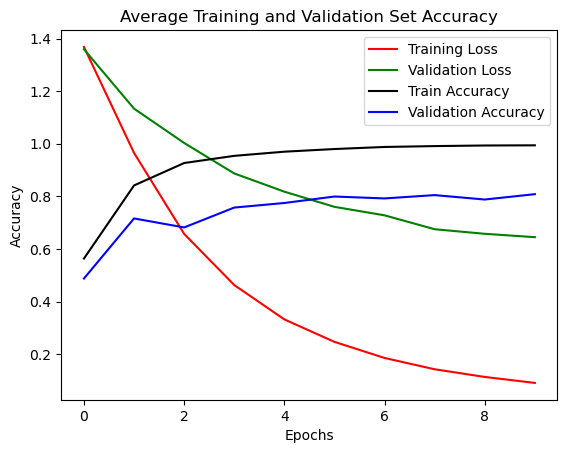

In [ ]:
# Plotting Training
plt.plot(history.history['loss'], '-', color='red', label='Training Loss')
plt.plot(history.history['val_loss'], '-', color='green', label='Validation Loss')
plt.plot(history.history['accuracy'], '-', color='black', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], '-', color='Blue', label='Validation Accuracy')
plt.title('Average Training and Validation Set Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
train_loss, train_acc = VGG16_model.evaluate(train_datagenerator, verbose=2)
val_loss, val_acc = VGG16_model.evaluate(val_datagenerator, verbose=2)
test_loss, test_acc = VGG16_model.evaluate(test_datagenerator, verbose=2)


print(f"Training Accuracy: {train_acc} and Training Loss: {train_loss}")
print(f"Validation Accuracy: {val_acc} and Validation Loss: {val_loss}")
print(f"Test Accuracy: {test_acc} and Test Loss: {test_loss}")

235/235 - 58s - loss: 0.0821 - accuracy: 0.9931 - 58s/epoch - 247ms/step
53/53 - 13s - loss: 0.6606 - accuracy: 0.7842 - 13s/epoch - 243ms/step
1670/1670 - 31s - loss: 0.6572 - accuracy: 0.7982 - 31s/epoch - 19ms/step
Training Accuracy: 0.9930823445320129 and Training Loss: 0.08207797259092331
Validation Accuracy: 0.7841726541519165 and Validation Loss: 0.6605651378631592
Test Accuracy: 0.7982035875320435 and Test Loss: 0.6572385430335999


In [ ]:
filename= test_datagenerator.filenames
nb_sample = len(test_datagenerator)
y_prob = []
y_act = []
test_datagenerator.reset()

for _ in range(nb_sample):
    X_test, Y_test = test_datagenerator.next()
    y_prob.append(VGG16_model.predict(X_test))
    y_act.append(Y_test)

VGG16_predict_class = [list(train_datagenerator.class_indices.keys())[i.argmax()] for i in y_prob]
VGG16_actual_classes = [list(train_datagenerator.class_indices.keys())[i.argmax()] for i in y_act]

1/1 [==============================] - 0s 18ms/step


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
classes = ['Left Log', 'Prone Left', 'Prone Right', 'Right Log', 'Supine_Thermal']
print("Test Result:================================================")
print(f"Accuracy Score: {accuracy_score(VGG16_actual_classes, VGG16_predict_class) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{classification_report(VGG16_actual_classes, VGG16_predict_class, target_names=classes)}")
print("_______________________________________________")
print(f"Confusion Matrix: \n{confusion_matrix(VGG16_actual_classes, VGG16_predict_class)}")

Test Result:================================================
Accuracy Score: 79.76%
_______________________________________________
CLASSIFICATION REPORT:
                precision    recall  f1-score   support

      Left Log       0.90      0.95      0.93       266
    Prone Left       0.69      0.87      0.77       361
   Prone Right       0.68      0.93      0.79       356
     Right Log       0.95      0.70      0.80       395
Supine_Thermal       1.00      0.54      0.71       292

      accuracy                           0.80      1670
     macro avg       0.84      0.80      0.80      1670
  weighted avg       0.84      0.80      0.79      1670

_______________________________________________
Confusion Matrix: 
[[254   0   8   4   0]
 [ 21 313  18   9   0]
 [  2  23 331   0   0]
 [  2  69  49 275   0]
 [  2  51  78   2 159]]


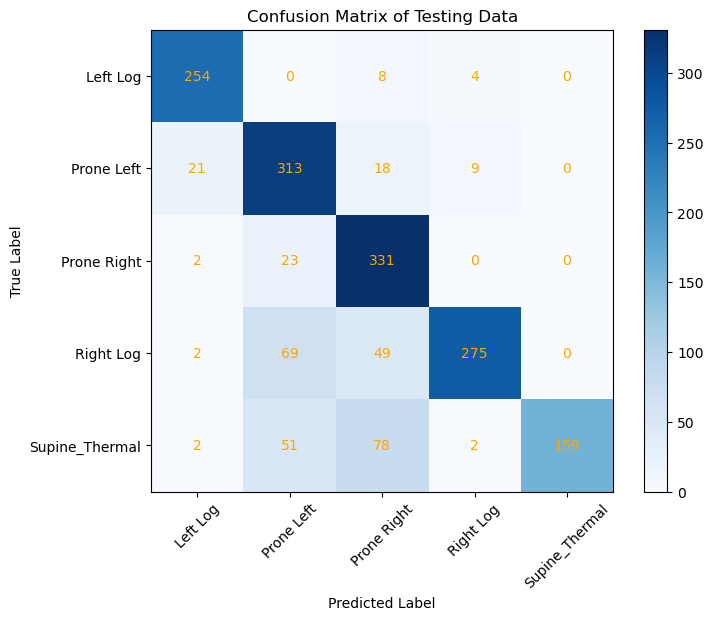

In [ ]:
class_labels = ['Left Log', 'Prone Left', 'Prone Right', 'Right Log', 'Supine_Thermal']  # Modify the labels based on your actual class names
VGG16_cm = confusion_matrix(VGG16_actual_classes, VGG16_predict_class)



# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(VGG16_cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix of Testing Data')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add labels to each cell cmap='Blues', annot=True, fmt='d'
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        plt.text(j, i, str(VGG16_cm[i, j]), ha='center', va='center', color='orange')

plt.show()